This notebook has been created by SEJAS Martin.

# Step 0: Analyzing Dataset

In [ ]:
# Importing necessary packages
import os 
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
import keras


from keras.backend import mean
from sklearn.metrics import mean_squared_error



**Dataset**

The dataset for this project is a bank fraud dataset in csv format with nearly ~600k rows with 9 features and 1 target. 

The features are: 
- *Customer*: A Customer unique identifier
</br>
</br>
- *Age*: Age Category of the customer in ranges with the following classes.
<p align="center">
</br>
	'0': <span width="15px"></span> <=18
</br>
</br>
	'1':  19-25
</br>
</br>
	'2':  26-35
</br>
</br>
	'3':  36-45
</br>
</br>
	'4':  46-55
</br>
</br>
	'5':  56-65
</br>
</br>
	'6':  >65
</br>
</br>
	U: Unknown
</br>

</p>

- *gender*: Gender of the customer 
</br>
</br>
<p align="center">
    E: Entreprise
	</br>
	</br>
	F: Female
	</br>
	</br>
	M: Male
	</br>
	</br>
	U: Unknown
	</br>
	</br>

</p>

- *zipcodeOri*: The zipcode the request is originating from.

- *merchant*: Id of the merchant

- *category*: Nature of the transaction
<p align="center">
</br>
</br>
	'es_transportation': Transport transaction
</br>
</br>
	'es_food': Food transaction
</br>
</br>
	'es_health': Health transaction
</br>
</br>
	'es_wellnessandbeauty': Wellness and beauty transaction
</br>
</br>
	'es_fashion': Fashion transaction
</br>
</br>
</p>

- *zipMerchant*: zipcode of the merchant

- *amount*: Price

The target is *fraud*:
<p align="center">
</br>
</br>
	 0: not a fraud
</br>
</br>
	 1: fraud
</p>



Hence this is a binary classification problem




# Step 1: Preprocessing

Visualizing the dataset

In [ ]:
# Loading the dataset into bf (bankfrauds) variable. Then, i wanna see its shape and the first 5 rows
bf = pd.read_csv('bank_frauds.csv')
print(bf.shape) 
print(bf.head())


(594643, 10)
   step       customer  age gender zipcodeOri       merchant zipMerchant  \
0     0  'C1093826151'  '4'    'M'    '28007'   'M348934600'     '28007'   
1     0   'C352968107'  '2'    'M'    '28007'   'M348934600'     '28007'   
2     0  'C2054744914'  '4'    'F'    '28007'  'M1823072687'     '28007'   
3     0  'C1760612790'  '3'    'M'    '28007'   'M348934600'     '28007'   
4     0   'C757503768'  '5'    'M'    '28007'   'M348934600'     '28007'   

              category  amount  fraud  
0  'es_transportation'    4.55      0  
1  'es_transportation'   39.68      0  
2  'es_transportation'   26.89      0  
3  'es_transportation'   17.25      0  
4  'es_transportation'   35.72      0  


Before building a neural network, we need to preprocess the data to make it suitable for deep learning.

Let's start with checking for missing values.

In [ ]:
bf.info()
print('-------------------------')
bf.isna().any()

    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  object 
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  object 
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB
-------------------------


step           False
customer       False
age            False
gender         False
zipcodeOri     False
merchant       False
zipMerchant    False
category       False
amount         False
fraud          False
dtype: bool

We can see that the range is 594643, and there is no Non-Null values (in the column of the count). 

So there is no need to deal with NaN datatypes in this dataset, it is already complete. This will save us some pre-processing time.

We can also perform some basic feature selection by checking the unique values per feature.

In [ ]:
print('Unique values per feature + (target).')
print('-------------------------')
for col in bf.columns:
    print(col,":", len(bf[col].unique()))

Unique values per feature + (target).
-------------------------
step : 180
customer : 4112
age : 8
gender : 4
zipcodeOri : 1
merchant : 50
zipMerchant : 1
category : 15
amount : 23767
fraud : 2


As you can see, *zipcodeOri* and *zipMerchant* only have **one** value for all instances, making it a redundant feature in our model. 

The *step* feature also does not have any relevant impact on fraud detection.

*Indicating all these features can later be dropped.*

On the 'Age' column, we have the 'Unknown' class which is not desirable for our model, as it is unreliable data. We have to check the proportion of this class in our dataset, to see if removing it is a viable option.

In [ ]:
age_unknown = bf.loc[bf.age == "'U'"] 

print('Unknown age cases:', len(age_unknown), '(', round(len(age_unknown)/len(bf) * 100,2), '%)')




Unknown age cases: 1178 ( 0.2 %)


Since the unknown age cases represent only 0.2% of our dataset we will remove it.

Now we want to check how our data set is balanced, we will analyze the ratio of frauds to non-frauds in our dataset, since this is the target value.

In [ ]:
data_fraud = bf.loc[bf.fraud == 1] 
data_not_fraud = bf.loc[bf.fraud == 0]

print('Fraud cases:', len(data_fraud), '(', round(len(data_fraud)/len(bf) * 100,2), '%)')
print('Not fraud cases:',len(data_not_fraud), '(', round(len(data_not_fraud)/len(bf) * 100,2), '%)')

Fraud cases: 7200 ( 1.21 %)
Not fraud cases: 587443 ( 98.79 %)


As shown above, we have a highly unbalanced dataset which can offset our metrics. This is an issue because a model that will predict all instances as 'Not fraud' will technically have an accuracy of nearly 99%, hence we have to take measures to address this unbalanced dataset problem.

We are going to use *stratification* to address this problem:

*Stratification*: Involves splitting the dataset into training and validation sets while ensuring that the proportion of classes is maintained in both sets. This can help prevent the model from being biased towards the majority class during training.

<br>


We also want to investigate the frauds per category any minority classes.

In [ ]:
#number of fraud per category
print(data_fraud.groupby('category').size())


category
'es_barsandrestaurants'     120
'es_fashion'                116
'es_health'                1696
'es_home'                   302
'es_hotelservices'          548
'es_hyper'                  280
'es_leisure'                474
'es_otherservices'          228
'es_sportsandtoys'         1982
'es_tech'                   158
'es_travel'                 578
'es_wellnessandbeauty'      718
dtype: int64


We can see it is also unbalanced depending on the transaction category, with classes like 'es_sportsandtoys' being over-represented compared to others, such as 'es_fashion', where there are 10x more instances of the former. 

Adopting this column into our stratification strategy may be useful. For now we want a general purpose model, and will not stratify this feature.


<br>
<hr>

As mentioned above, we can perform feature selection by dropping the columns that are not useful for the study and convert categorical variables into numerical ones by using encoding techniques.


Additionally, some other pre-processing formatting is needed such as removing the ' ' characters from the column row values.

Dropping previously unnecessary features

In [ ]:
#making a copy of the original untouched dataset if needed
bf_copy = bf.copy()

#dropping unnecessary features
bf.drop(['step', 'zipcodeOri', 'zipMerchant'], axis=1, inplace=True)

bf.head()

,customer,age,gender,merchant,category,amount,fraud
0,'C1093826151','4','M','M348934600','es_transportation',4.55,0
1,'C352968107','2','M','M348934600','es_transportation',39.68,0
2,'C2054744914','4','F','M1823072687','es_transportation',26.89,0
3,'C1760612790','3','M','M348934600','es_transportation',17.25,0
4,'C757503768','5','M','M348934600','es_transportation',35.72,0


If you see above we have all our categorical data wrapped with quotations. We will clean the data by removing the ' ' characters.

In [ ]:
remove_columns = ['customer', 'age', 'gender','merchant','category']
# Apply the lambda function to all string columns in the DataFrame
bf[remove_columns] = bf[remove_columns].applymap(lambda x: x.replace("'", ""))

bf.head()

,customer,age,gender,merchant,category,amount,fraud
0,C1093826151,4,M,M348934600,es_transportation,4.55,0
1,C352968107,2,M,M348934600,es_transportation,39.68,0
2,C2054744914,4,F,M1823072687,es_transportation,26.89,0
3,C1760612790,3,M,M348934600,es_transportation,17.25,0
4,C757503768,5,M,M348934600,es_transportation,35.72,0


We will also remove the 'Unknown' class 'U' from our age feature, as stated above. 

In [ ]:
bf['age'] = bf['age'].astype('category')
print("before: ",bf['age'].cat.categories)
bf['age'] = bf['age'].cat.remove_categories('U')
print("after: ", bf['age'].cat.categories)

before:  Index(['0', '1', '2', '3', '4', '5', '6', 'U'], dtype='object')
after:  Index(['0', '1', '2', '3', '4', '5', '6'], dtype='object')


Splitting our data into training, validation and testing datasets. While stratifying y to maintain balance.

In [ ]:
from sklearn.model_selection import train_test_split

#splitting target column from dataset
X = bf.copy()
y = X.pop('fraud').to_numpy() #the label

#splitting 10% validation set and 10% test set as required by the specifications
#As mentioned before we are dealing with an unbalanced data set, so we are stratifying our target label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1/(1-0.1), random_state=42, stratify=y_train)



All categorical variables must be encoded, and numerical normalized

Neural networks are sensitive to inputs and hence to ensure consistent data through the layers this step is essential.

In [ ]:
#import pre-processing tools
from sklearn.preprocessing import (OneHotEncoder, 
                                   StandardScaler)

from sklearn.compose import ColumnTransformer 


#No need for a label encoder for our target as it is already in binary form. 
# we need to one hot encode customer, age, gender, merchant, and category
    

#For categorical variables
ohe = OneHotEncoder(drop='if_binary', handle_unknown='ignore')
std = StandardScaler()

#encode all columns except amount
cat_col = X_train.select_dtypes(include=['object', 'category']).columns
num_col = X_train.drop(columns=cat_col).columns


ct = ColumnTransformer([('cat', ohe, cat_col),
                        ('num', std, num_col)])

X_train_t = ct.fit_transform(X_train)
X_val_t = ct.transform(X_val)
X_test_t = ct.transform(X_test)

X_train_t.shape, X_train.shape




((475713, 4190), (475713, 6))

As you can see with the difference between the original dataset and the encoded dataset we thousands of more features, which will require a neural network.

Pre-processing is complete we can proceed with building our model.


<br>
<hr>



# Step 2: Building the Neural Network

### We can proceed to build a neural network on the training data using TensorFlow/Keras.


There are many decisions to be made when designing a Neural Network, we will explain why we believe the chosen parameters are the best to tackle the problem. 

***Activation Function***: The chosen activation function is SELU, for us this was a straightforward choice as it deals with the vanishing-exploding gradient problem, and performs better than RELU. SELU known to be constraint heavy, but our model fits the requirements, we are dealing with a Sequential Model, have normalized our data, and are making sure to use leCun activation for weights initialization of each layer. 

***Output Function***: This is a no-brainer, we have a binary classification problem, our output function is a sigmoid function. 

***Controlling Overfitting***: We decided to control overfitting by using Early Stopping. Not only is this an efficient Regularization technique, it will save us time as we explore different architectures for our model. We have decided to monitor validation loss, with a patience of 3. If the validation loss does not improve in 3 epochs we stop the training and restore the best weights.

***Optimizer***: For the optimizer we will use the default AdamW with a varying learning rate.

***Hyperparameter Tuning***: To tune the learning rate we have decided to implement a learning scheduler in our model. We have a starting learning rate of 0.05, that will be halved every time until epoch 6, after this we implement an exponential decay to the learning rate.

***Model Architecture***: For our model architecture we implemented many different configurations. We found that adding anything more than 2 dense layers would make our problem overlycomplex and before badly. Additionally due to the large amount of features of the transformed data set, we found the need of having stacked hidden layers with 1024 neurons each. We found using a binary number to increase the performance of our model. 

The accuracy metric may not be appropriate for imbalanced datasets such as this one.  we may use precision, recall, and F1 score that take into account the imbalance between the classes.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Dense, Activation
from keras.initializers import lecun_normal
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.metrics import Accuracy, Precision, Recall, AUC




def reset_seeds():
    os.environ['PYTHONHASHSEED']=str(2)
    tf.random.set_seed(2)
    np.random.seed(2)
    random.seed(2)

tf.keras.backend.clear_session()
reset_seeds()



# Architecture

inputs = tf.keras.Input((X_train_t.shape[1],))

dense_1 = tf.keras.layers.Dense(1024, kernel_initializer=lecun_normal(), activation='selu')(inputs)

dense_2 = tf.keras.layers.Dense(1024, kernel_initializer=lecun_normal(), activation='selu')(dense_1)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense_2)

bench_model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compiling
#change optimizer to adamW
bench_model.compile(optimizer=tf.keras.optimizers.experimental.AdamW(0.05), #default lr is 0.001
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=[Accuracy(), Precision(), Recall(), AUC()])

#Function for our learning rate tuning, half until epoch 6 and then apply exponential decay
def scheduler(epoch, lr):
  if epoch < 6:
    return lr/2
  else:
    return lr * tf.math.exp(-0.1)

#Hyperparameter control (learning rate) using a Learning Scheduler
lr_schedule = LearningRateScheduler(scheduler)

## overfitting tools - early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)


# Training
epochs = 15
batch_size = 32
bench_history = bench_model.fit(X_train_t, y_train,
                                epochs=epochs,
                                batch_size=batch_size,
                                validation_data=(X_val_t, y_val), callbacks=[lr_schedule, early_stopping])

Epoch 1/15
14867/14867 [==============================] - 120s 8ms/step - loss: 0.5057 - accuracy: 0.8928 - precision: 0.5996 - recall: 0.6023 - auc: 0.8225 - val_loss: 1.3849 - val_accuracy: 0.9538 - val_precision: 0.2415 - val_recall: 0.9819 - val_auc: 0.9730 - lr: 0.0250
Epoch 2/15
14867/14867 [==============================] - 108s 7ms/step - loss: 0.2945 - accuracy: 0.9083 - precision: 0.7248 - recall: 0.7253 - auc: 0.8800 - val_loss: 0.1325 - val_accuracy: 0.9398 - val_precision: 0.8958 - val_recall: 0.7639 - val_auc: 0.8925 - lr: 0.0125
Epoch 3/15
14867/14867 [==============================] - 109s 7ms/step - loss: 0.0744 - accuracy: 0.8585 - precision: 0.7701 - recall: 0.7670 - auc: 0.9113 - val_loss: 0.0579 - val_accuracy: 0.8693 - val_precision: 0.9553 - val_recall: 0.6833 - val_auc: 0.9100 - lr: 0.0063
Epoch 4/15
14867/14867 [==============================] - 112s 7ms/step - loss: 0.0362 - accuracy: 0.7551 - precision: 0.8105 - recall: 0.8021 - auc: 0.9404 - val_loss: 0.0382

# Step 3: Evaluating the Model

In [ ]:
from keras.utils.vis_utils import plot_model


plot_model(bench_model,to_file= 'model_plot.png',show_shapes=True,show_layer_names=True)

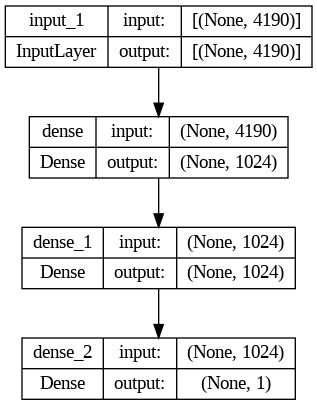

{'loss': [0.5056654810905457, 0.29451632499694824, 0.07438020408153534, 0.0362212099134922, 0.018227800726890564, 0.010997315868735313, 0.00832892395555973, 0.007884468883275986, 0.007493716198951006, 0.00725776981562376], 'accuracy': [0.8928345441818237, 0.9082682132720947, 0.8584503531455994, 0.7551443576812744, 0.8920504450798035, 0.71928870677948, 0.44140270352363586, 0.15157458186149597, 0.015198239125311375, 0.008172995410859585], 'precision': [0.5995506644248962, 0.7248438596725464, 0.7700889110565186, 0.8105263113975525, 0.8361840844154358, 0.8702112436294556, 0.8807438015937805, 0.8864699602127075, 0.8870419859886169, 0.892773449420929], 'recall': [0.6022569537162781, 0.7253472208976746, 0.7670139074325562, 0.8020833134651184, 0.8232638835906982, 0.8439236283302307, 0.8552083373069763, 0.855381965637207, 0.8616319298744202, 0.8600694537162781], 'auc': [0.8224756717681885, 0.8800438046455383, 0.911261796951294, 0.9404454231262207, 0.9666367769241333, 0.9863311648368835, 0.99312

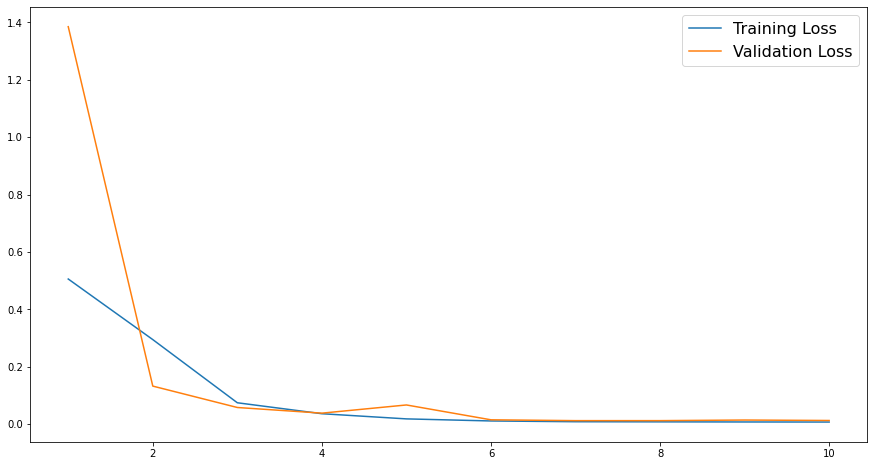

In [ ]:
# Learning Curves
bench_loss = bench_history.history

print(bench_loss)
print(len(bench_loss['loss']))
print(len(bench_loss['val_loss']))

plt.figure(figsize=(15,8))

plt.plot(np.arange(1,len(bench_loss['loss'])+1), bench_loss['loss'], label='Training Loss')
plt.plot(np.arange(1,len(bench_loss['loss'])+1), bench_loss['val_loss'], label='Validation Loss')

plt.legend(fontsize=16)
plt.show()

In [ ]:
# we call after the training to evaluate the model
loss, accuracy, precision, recall, auc = bench_model.evaluate(X_test_t, y_test)

1859/1859 [==============================] - 8s 4ms/step - loss: 0.0130 - accuracy: 0.3248 - precision: 0.8356 - recall: 0.8542 - auc: 0.9836


[0.012964734807610512,
 0.3248465359210968,
 0.835597813129425,
 0.8541666865348816,
 0.9835756421089172]

#Step 4: Conclusion 

Since this is a binary classification problem, focusing on bank fraud. We decided that the desired most performing metrics to be precision, recall, and fscore. As said before our dataset is very unbalanced so accuracy in itself is not a representative metric. 

Hence we are satisfied by a precision of 0.8356 and a recall of 0.8542, especially considering this dataset does not have a lot of features. 

We can further evaluate our model by calculating the fscore.

In [ ]:
fscore = 2 * ( (precision*recall) / (precision+recall))

fscore

0.844780222875256

With a fscore of 0.8448 with such a highly unbalanced dataset with few features we consider this as a great result and are happy with it. More data and more training would be recommended to improve the model even more, and achieve a performance that would be suitable for production and real-life applications.